In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# Daily S&P index for 10 years from 2013
# https://www.nasdaq.com/market-activity/index/spx/historical
# Select max date range and download csv file
# csv_file = 'blob:https://www.nasdaq.com/b88f9de1-47b1-4050-861d-140af8d5354d'
csv_file = '../data/spx_HistoricalData.csv'

df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Close/Last'])
df.head()

,Date,Close/Last
0,12/06/2023,4549.34
1,12/05/2023,4567.18
2,12/04/2023,4569.78
3,12/01/2023,4594.63
4,11/30/2023,4567.80


In [21]:
df.rename(columns={'Close/Last': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2013-12-09,1808.37
2013-12-10,1802.62
2013-12-11,1782.22
2013-12-12,1775.50
2013-12-13,1775.32


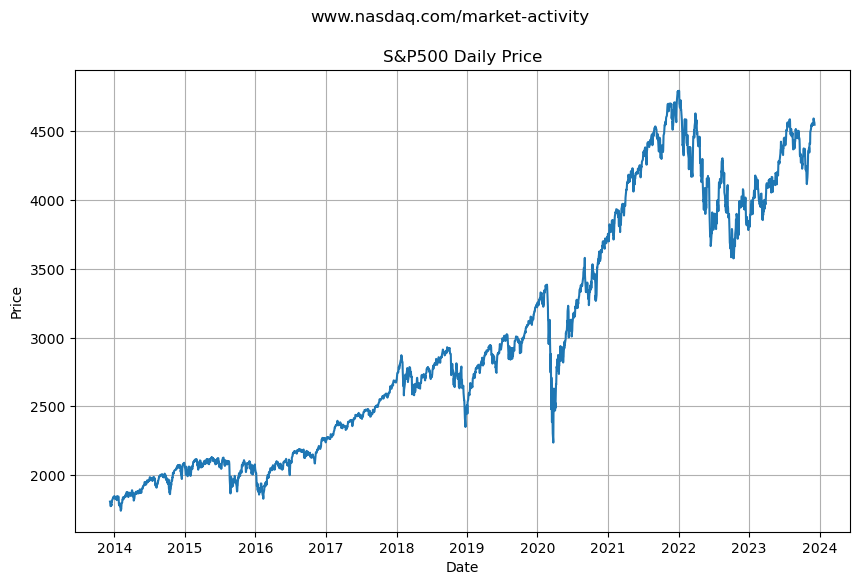

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.suptitle('www.nasdaq.com/market-activity')
plt.title('S&P500 Daily Price')
plt.grid(True)
plt.show()